In [ ]:
# ============================== ViT CIFAR-10 w/ Auto-Teacher KD (A100-tuned, strong RN50 teacher in 300 ep) ==============================
# Trains a stronger ResNet50 teacher (AMP + EMA + MixUp/CutMix + TrivialAugWide + RandomErasing),
# then ViT student with KD. Saves teacher ckpt and student best/last/every_50.
# =======================================================================================================================================

import os, time, random, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import models as tvm
from torchvision.transforms import (
    Compose as TvCompose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip,
    TrivialAugmentWide, RandomErasing
)

# ---------------- Config ----------------
SEED              = 1337

# Student
EPOCHS            = 300
BATCH_TRAIN       = 192
BATCH_TEST        = 512
BASE_LR           = 6e-4
WEIGHT_DECAY      = 0.05
LABEL_SMOOTH_MAX  = 0.05
WARMUP_FRAC       = 0.05
SAVE_EVERY        = 50

# Teacher
USE_KD            = True
TEACHER_ARCH      = "resnet50"
TEACHER_EPOCHS    = 300        # more training for RN50
TEACHER_LR        = 0.4
TEACHER_WD        = 5e-4
TEACHER_MOM       = 0.9
TEACHER_LABEL_SMOOTH = 0.10
TEACHER_CKPT      = "teacher_resnet50_cifar10.pt"   # will be created if missing
KD_T              = 2.0
KD_ALPHA          = 0.5

# Model scale (student)
IMG_SIZE          = 32
PATCH_SIZE        = 4
EMB_DIM           = 256
N_LAYERS          = 12
N_HEADS           = 8
MLP_RATIO         = 4
DROPOUT           = 0.05
DROPPATH          = 0.15
N_CLASSES         = 10
N_CLS_BLOCKS      = 4

# Misc
MEAN              = (0.4914, 0.4822, 0.4465)
STD               = (0.2470, 0.2435, 0.2616)
USE_AMP           = True
COMPILE           = True  # set True if your environment supports torch.compile

# ---------------- Repro & speed knobs ------------------
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed()

device = "cuda" if torch.cuda.is_available() else "cpu"
print("torch:", torch.__version__)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass
torch.backends.cudnn.benchmark = True  # allow autotuner (non-deterministic but fast)

# ---------------- Data -------------------
train_tfms = TvCompose([
    TrivialAugmentWide(),
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(MEAN, STD),
    RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), inplace=True),
])

test_tfms = TvCompose([ToTensor(), Normalize(MEAN, STD)])

train_set = CIFAR10(root=".", train=True,  download=True, transform=train_tfms)
test_set  = CIFAR10(root=".", train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_set, batch_size=BATCH_TRAIN, shuffle=True,
                          num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_TEST, shuffle=False,
                          num_workers=4, pin_memory=True, persistent_workers=True)

# ---------------- Mixup / CutMix -------------------
def rand_bbox(W, H, lam, device):
    cut_rat = (1. - lam) ** 0.5
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx = torch.randint(0, W, (1,), device=device).item()
    cy = torch.randint(0, H, (1,), device=device).item()
    x1 = max(cx - cut_w // 2, 0); y1 = max(cy - cut_h // 2, 0)
    x2 = min(cx + cut_w // 2, W); y2 = min(cy + cut_h // 2, H)
    return x1, y1, x2, y2

def mixup_data(x, y, alpha=0.4):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    return x_mix, y, y[idx], lam

def cutmix_data(x, y, alpha=1.0):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    _, _, H, W = x.shape
    x1, y1, x2, y2 = rand_bbox(W, H, lam, x.device)
    x_cut = x.clone()
    x_cut[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam_adj = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    return x_cut, y, y[idx], lam_adj

def mixed_criterion(criterion, logits, y_a, y_b, lam):
    return lam * criterion(logits, y_a) + (1 - lam) * criterion(logits, y_b)

# ---------------- EMA -------------------
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in model.state_dict().items() if torch.is_floating_point(v)}
        self.backup = None
    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            if torch.is_floating_point(v):
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1.0 - self.decay)
    @torch.no_grad()
    def store(self, model):
        self.backup = {k: v.detach().clone() for k, v in model.state_dict().items()}
    @torch.no_grad()
    def copy_to(self, model):
        mstate = model.state_dict()
        for k, v in self.shadow.items():
            if k in mstate and torch.is_floating_point(mstate[k]):
                mstate[k].copy_(v)
        model.load_state_dict(mstate, strict=True)
    @torch.no_grad()
    def restore(self, model):
        if self.backup is not None:
            model.load_state_dict(self.backup, strict=True); self.backup = None

# ---------------- ViT Student ------------------
class PreNorm(nn.Module):
    def __init__(self, dim, fn): super().__init__(); self.norm = nn.LayerNorm(dim); self.fn = fn
    def forward(self, x): return self.fn(self.norm(x))

class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden, dropout=0.0):
        super().__init__(nn.Linear(dim, hidden), nn.GELU(), nn.Dropout(dropout),
                         nn.Linear(hidden, dim), nn.Dropout(dropout))

class DropPath(nn.Module):
    def __init__(self, p=0.0): super().__init__(); self.p=float(p)
    def forward(self, x):
        if self.p==0.0 or not self.training: return x
        keep=1.0-self.p; shape=(x.shape[0],)+(1,)*(x.ndim-1)
        return x* x.new_empty(shape).bernoulli_(keep).div_(keep)

class RelPosAttention(nn.Module):
    def __init__(self, dim, n_heads, dropout, grid):
        super().__init__(); assert dim % n_heads ==0
        self.n_heads=n_heads; self.head_dim=dim//n_heads; self.scale=self.head_dim**-0.5
        self.qkv=nn.Linear(dim, dim*3, bias=True); self.proj=nn.Linear(dim, dim)
        self.attn_drop=nn.Dropout(dropout); self.proj_drop=nn.Dropout(dropout)
        Gh,Gw=grid; N=Gh*Gw; num_rel=(2*Gh-1)*(2*Gw-1)
        self.rel_bias=nn.Parameter(torch.zeros(n_heads, num_rel))
        self.special_to_patch=nn.Parameter(torch.zeros(n_heads,2,N))
        self.patch_to_special=nn.Parameter(torch.zeros(n_heads,2,N))
        self.special_to_special=nn.Parameter(torch.zeros(n_heads,2,2))
        coords=torch.stack(torch.meshgrid(torch.arange(Gh), torch.arange(Gw), indexing='ij'))
        coords_flat=coords.flatten(1); rel=coords_flat[:,:,None]-coords_flat[:,None,:]
        rel[0]+=Gh-1; rel[1]+=Gw-1; rel_idx=rel[0]*(2*Gw-1)+rel[1]
        self.register_buffer("rel_index", rel_idx, persistent=False)
    def forward(self, x):
        B,S,D=x.shape; N=self.rel_index.shape[0]; k=S-N; assert k in (1,2)
        qkv=self.qkv(x).reshape(B,S,3,self.n_heads,self.head_dim).permute(2,0,3,1,4)
        q,kv_k,v=qkv[0],qkv[1],qkv[2]; attn=(q @ kv_k.transpose(-2,-1))*self.scale
        attn_ss=attn[:,:,:k,:k]; attn_sp=attn[:,:,:k,k:]; attn_ps=attn[:,:,k:,:k]; attn_pp=attn[:,:,k:,k:]
        rb=self.rel_bias[:, self.rel_index.view(-1)].view(self.n_heads, N, N)
        attn_pp=attn_pp+rb.unsqueeze(0); attn_sp=attn_sp+self.special_to_patch[:,:k,:].unsqueeze(0)
        attn_ps=attn_ps+self.patch_to_special[:,:k,:].permute(0,2,1).unsqueeze(0)
        attn_ss=attn_ss+self.special_to_special[:,:k,:k].unsqueeze(0)
        attn=torch.cat([torch.cat([attn_ss,attn_sp],-1), torch.cat([attn_ps,attn_pp],-1)], -2)
        attn=attn.softmax(-1); attn=self.attn_drop(attn)
        out=(attn @ v).transpose(1,2).reshape(B,S,D); out=self.proj(out); return self.proj_drop(out)

class PatchEmbedding(nn.Module):
    def __init__(self, ch=3, patch=PATCH_SIZE, emb=EMB_DIM):
        super().__init__(); self.patch_size=patch
        self.conv_stem=nn.Sequential(nn.Conv2d(ch, emb, 3,1,1, bias=False), nn.BatchNorm2d(emb), nn.GELU())
        self.unfold=nn.Unfold(kernel_size=patch, stride=patch); self.proj=nn.Linear(emb*patch*patch, emb)
    def forward(self, x):
        x=self.conv_stem(x); patches=self.unfold(x).transpose(1,2); return self.proj(patches)

class ClassAttentionBlock(nn.Module):
    def __init__(self, dim, heads, dropout, mlp_ratio, dp, grid):
        super().__init__(); self.attn=PreNorm(dim, RelPosAttention(dim, heads, dropout, grid))
        self.dp1=DropPath(dp); self.mlp=PreNorm(dim, FeedForward(dim,int(dim*mlp_ratio),dropout)); self.dp2=DropPath(dp)
    def forward(self, x):
        cls,tokens=x[:,:1,:], x[:,1:,:]; x_all=torch.cat([cls,tokens],1)
        cls=cls + self.dp1(self.attn(x_all))[:,:1,:]; cls=cls + self.dp2(self.mlp(cls))
        return torch.cat([cls,tokens],1)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, dropout, mlp_ratio, dp, grid):
        super().__init__(); self.attn=PreNorm(dim, RelPosAttention(dim, heads, dropout, grid))
        self.dp1=DropPath(dp); self.mlp=PreNorm(dim, FeedForward(dim,int(dim*mlp_ratio),dropout)); self.dp2=DropPath(dp)
    def forward(self, x): x=x+self.dp1(self.attn(x)); x=x+self.dp2(self.mlp(x)); return x

class ViT(nn.Module):
    def __init__(self, ch=3, img=IMG_SIZE, patch=PATCH_SIZE, emb=EMB_DIM,
                 n_layers=N_LAYERS, heads=N_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH, out_dim=N_CLASSES, n_cls_blocks=N_CLS_BLOCKS):
        super().__init__(); assert img % patch == 0
        self.patch=PatchEmbedding(ch, patch, emb); Gh=Gw=img//patch; self.grid=(Gh,Gw); N=Gh*Gw
        self.cls_token=nn.Parameter(torch.zeros(1,1,emb)); self.dist_token=nn.Parameter(torch.zeros(1,1,emb))
        self.pos_embed=nn.Parameter(torch.zeros(1,N+2,emb))
        blocks=[]
        for i in range(n_layers):
            dp_i=droppath*float(i)/max(1,n_layers-1)
            if i>=n_layers-n_cls_blocks: blocks.append(ClassAttentionBlock(emb,heads,dropout,mlp_ratio,dp_i,self.grid))
            else: blocks.append(TransformerBlock(emb,heads,dropout,mlp_ratio,dp_i,self.grid))
        self.layers=nn.ModuleList(blocks)
        self.head_cls=nn.Sequential(nn.LayerNorm(emb), nn.Linear(emb,out_dim))
        self.head_dist=nn.Sequential(nn.LayerNorm(emb), nn.Linear(emb,out_dim))
        nn.init.trunc_normal_(self.cls_token,std=0.02); nn.init.trunc_normal_(self.dist_token,std=0.02)
        nn.init.trunc_normal_(self.pos_embed,std=0.02)
    def forward(self, img, return_both=False):
        x=self.patch(img); B,N,D=x.shape; cls=self.cls_token.expand(B,1,D); dist=self.dist_token.expand(B,1,D)
        x=torch.cat([cls,dist,x],1); x=x+self.pos_embed[:,:N+2,:]
        for blk in self.layers: x=blk(x)
        cls_out=self.head_cls(x[:,0,:]); dist_out=self.head_dist(x[:,1,:])
        return (cls_out, dist_out) if return_both else 0.5*(cls_out+dist_out)

# ---------------- Teacher (KD) ----------------
def build_teacher(arch=TEACHER_ARCH, n_classes=10):
    if arch=="resnet18": return tvm.resnet18(weights=None, num_classes=n_classes)
    if arch=="resnet50": return tvm.resnet50(weights=None, num_classes=n_classes)
    raise ValueError(f"Unknown teacher arch: {arch}")

def train_teacher_if_needed(path=TEACHER_CKPT):
    if os.path.isfile(path):
        print(f"[KD] Using existing teacher: {path}")
        return path
    print("[KD] Training stronger teacher from scratch…")

    model = build_teacher().to(device).to(memory_format=torch.channels_last)

    # --- teacher param counts & hyperparams (pre-training) ---
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[Teacher] arch={TEACHER_ARCH} | params(total/trainable): {total_params:,} / {trainable_params:,}")
    print(f"[Teacher] epochs={TEACHER_EPOCHS} | lr={TEACHER_LR} | wd={TEACHER_WD} | mom={TEACHER_MOM} | "
          f"label_smooth={TEACHER_LABEL_SMOOTH}")

    steps_per_epoch = len(train_loader)

    # --- coarse total time estimate before training ---
    est_per_step_sec = 0.025   # tune after a short run on your GPU (A100 ~0.02–0.03 s/step)
    est_total_time_min = (steps_per_epoch * TEACHER_EPOCHS * est_per_step_sec) / 60
    print(f"[Teacher] Estimated total training time ≈ {est_total_time_min:.1f} minutes "
          f"({est_total_time_min/60:.2f} hours) based on {steps_per_epoch} steps/epoch.\n")

    ema = EMA(model, decay=0.999)
    scaler = torch.amp.GradScaler(device="cuda", enabled=USE_AMP)
    criterion = nn.CrossEntropyLoss(label_smoothing=TEACHER_LABEL_SMOOTH)
    optimizer = torch.optim.SGD(model.parameters(), lr=TEACHER_LR, momentum=TEACHER_MOM, weight_decay=TEACHER_WD, nesterov=True)

    total_steps = TEACHER_EPOCHS * steps_per_epoch
    warmup_steps = max(1, int(0.05 * total_steps))
    warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_steps)
    cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, total_steps - warmup_steps))
    sched = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_steps])

    best=0.0; t0=time.time()
    model.train()

    def teacher_strong_phase(ep): return ep <= TEACHER_EPOCHS - 15

    @torch.no_grad()
    def eval_once():
        model.eval(); ema.store(model); ema.copy_to(model)
        tot=0; correct=0; loss_sum=0.0
        for x,y in test_loader:
            x=x.to(device, non_blocking=True).to(memory_format=torch.channels_last); y=y.to(device, non_blocking=True)
            logits=model(x); loss=criterion(logits,y)
            loss_sum+=loss.item()*x.size(0); correct+=(logits.argmax(1)==y).sum().item(); tot+=x.size(0)
        ema.restore(model); model.train()
        return loss_sum/tot, correct/tot

    for ep in range(1, TEACHER_EPOCHS+1):
        ep_start = time.time()
        losses=[]
        ema.decay = 0.995 + (0.9995 - 0.995) * (ep / TEACHER_EPOCHS)

        for x,y in train_loader:
            x=x.to(device, non_blocking=True).to(memory_format=torch.channels_last); y=y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            if teacher_strong_phase(ep):
                if torch.rand(()) < 0.5: x_aug, ya, yb, lam = cutmix_data(x,y,1.0)
                else:                    x_aug, ya, yb, lam = mixup_data(x,y,0.4)
            else:
                x_aug, ya, yb, lam = x, y, y, 1.0

            with torch.amp.autocast(device_type="cuda", enabled=USE_AMP):
                logits=model(x_aug)
                ls_now = TEACHER_LABEL_SMOOTH if teacher_strong_phase(ep) else 0.0
                ce_cur = nn.CrossEntropyLoss(label_smoothing=ls_now)
                loss = mixed_criterion(ce_cur, logits, ya, yb, lam)

            # AMP-safe grad clipping (unscale -> clip -> step)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()

            sched.step()
            ema.update(model)
            losses.append(loss.item())

        te_loss, te_acc = eval_once()
        if te_acc>best:
            best=te_acc
            # save EMA weights that achieved the best score
            ema.store(model)
            ema.copy_to(model)
            torch.save({k:v.detach().cpu() for k,v in model.state_dict().items()}, path)
            ema.restore(model)

        ep_time = time.time() - ep_start
        elapsed_m = (time.time() - t0)/60.0
        print(f"[Teacher] Ep {ep:03d}/{TEACHER_EPOCHS} | train {np.mean(losses):.4f} | test {te_loss:.4f} | "
              f"acc {te_acc:.4f} | best {best:.4f} | epoch {ep_time:.1f}s | elapsed {elapsed_m:.1f}m")

    print(f"[KD] Teacher saved to {path} (best acc {best:.4f})")
    return path

# ---------------- Student training ----------------
def main():
    # --- Build student first just to print params before teacher training ---
    student_probe = ViT().to(device).to(memory_format=torch.channels_last)
    s_total = sum(p.numel() for p in student_probe.parameters())
    s_train = sum(p.numel() for p in student_probe.parameters() if p.requires_grad)
    print(f"[Student] ViT params(total/trainable): {s_total:,} / {s_train:,}")
    # free probe to keep memory clean before teacher training
    del student_probe
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Train / load teacher
    teacher_path = train_teacher_if_needed(TEACHER_CKPT) if USE_KD else None
    teacher = None
    if USE_KD:
        teacher = build_teacher().to(device).to(memory_format=torch.channels_last).eval()
        state = torch.load(teacher_path, map_location="cpu")
        teacher.load_state_dict(state if isinstance(state, dict) else state["state_dict"], strict=False)
        for p in teacher.parameters(): p.requires_grad=False
        print("[KD] Teacher ready.")

    # Re-create student for actual training
    student = ViT().to(device).to(memory_format=torch.channels_last)
    if COMPILE:
        try:
            student = torch.compile(student)
        except Exception as e:
            print(f"[compile] skipped: {e}")

    ema = EMA(student, decay=0.999)
    scaler = torch.amp.GradScaler(device="cuda", enabled=USE_AMP)
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH_MAX)

    # fused AdamW only when CUDA is available
    use_fused = (device == "cuda")
    optimizer = torch.optim.AdamW(student.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY, fused=use_fused)

    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = max(1, int(WARMUP_FRAC * total_steps))
    warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_steps)
    cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, total_steps - warmup_steps))
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_steps])

    best_acc = 0.0; t0_total=time.time()

    @torch.no_grad()
    def evaluate(loader):
        student.eval(); ema.store(student); ema.copy_to(student)
        tot_loss=0.0; correct=0; seen=0
        for x,y in loader:
            x=x.to(device, non_blocking=True).to(memory_format=torch.channels_last); y=y.to(device, non_blocking=True)
            logits = student(x)
            loss = criterion(logits, y)
            tot_loss += loss.item()*x.size(0)
            correct  += (logits.argmax(1)==y).sum().item()
            seen     += x.size(0)
        ema.restore(student); student.train()
        return tot_loss/seen, correct/seen

    for ep in range(1, EPOCHS+1):
        t0=time.time(); student.train(); losses=[]
        strong_phase = (ep <= EPOCHS - 15)
        ema.decay = 0.995 + (0.9995 - 0.995) * (ep / EPOCHS)

        for x,y in train_loader:
            x=x.to(device, non_blocking=True).to(memory_format=torch.channels_last); y=y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            if strong_phase:
                if torch.rand(()) < 0.5: x_aug, ya, yb, lam = cutmix_data(x,y,1.0)
                else:                    x_aug, ya, yb, lam = mixup_data(x,y,0.4)
            else:
                x_aug, ya, yb, lam = x, y, y, 1.0

            with torch.amp.autocast(device_type="cuda", enabled=USE_AMP):
                cls_logits, dist_logits = student(x_aug, return_both=True)
                ls_now = LABEL_SMOOTH_MAX if strong_phase else 0.0
                ce = nn.CrossEntropyLoss(label_smoothing=ls_now)
                ce_loss = mixed_criterion(ce, cls_logits, ya, yb, lam)

                if USE_KD and teacher is not None:
                    with torch.no_grad():
                        t_logits = teacher(x_aug)
                    kd_loss = F.kl_div(
                        F.log_softmax(dist_logits / KD_T, dim=1),
                        F.softmax(t_logits / KD_T, dim=1),
                        reduction="batchmean"
                    ) * (KD_T * KD_T)
                    loss = KD_ALPHA * kd_loss + (1.0 - KD_ALPHA) * ce_loss
                else:
                    ce_dist = mixed_criterion(ce, dist_logits, ya, yb, lam)
                    loss = 0.5*(ce_loss + ce_dist)

            # AMP-safe grad clipping (unscale -> clip -> step)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()
            scheduler.step(); ema.update(student)
            losses.append(loss.item())

        tr_loss = float(np.mean(losses)) if losses else 0.0
        te_loss, te_acc = evaluate(test_loader)

        if ep % SAVE_EVERY == 0:
            torch.save({k:v.detach().cpu() for k,v in student.state_dict().items()}, f"vit_cifar10_ep{ep}.pt")
        if te_acc > best_acc:
            best_acc = te_acc
            # save EMA weights that achieved the best score
            ema.store(student)
            ema.copy_to(student)
            torch.save({k:v.detach().cpu() for k,v in student.state_dict().items()}, "vit_cifar10_best.pt")
            ema.restore(student)

        epoch_sec = time.time()-t0; elapsed_total=time.time()-t0_total
        lr_now = optimizer.param_groups[0]["lr"]
        print(f"Epoch {ep:03d} | lr {lr_now:.2e} | train {tr_loss:.4f} | test {te_loss:.4f} | acc {te_acc:.4f} "
              f"| best {best_acc:.4f} | epoch {epoch_sec:.1f}s | total {elapsed_total/60:.1f}m")

    torch.save({k:v.detach().cpu() for k,v in student.state_dict().items()}, "vit_cifar10_last.pt")

    x,y = next(iter(test_loader)); x=x.to(device).to(memory_format=torch.channels_last); y=y.to(device)
    with torch.no_grad():
        preds = student(x).argmax(1)
    print("Pred classes:", preds[:16].tolist())
    print("True  classes:", y[:16].tolist())
    print("\nSaved files:\n - teacher_resnet50_cifar10.pt\n - vit_cifar10_best.pt\n - vit_cifar10_last.pt\n - vit_cifar10_ep{...}.pt every", SAVE_EVERY, "epochs")

if __name__ == "__main__":
    main()


torch: 2.8.0+cu126
GPU: NVIDIA A100-SXM4-40GB


100%|██████████| 170M/170M [00:01<00:00, 105MB/s]


[Student] ViT params(total/trainable): 10,603,508 / 10,603,508
[KD] Training stronger teacher from scratch…
[Teacher] arch=resnet50 | params(total/trainable): 23,528,522 / 23,528,522
[Teacher] epochs=300 | lr=0.4 | wd=0.0005 | mom=0.9 | label_smooth=0.1
[Teacher] Estimated total training time ≈ 32.6 minutes (0.54 hours) based on 261 steps/epoch.



/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[Teacher] Ep 001/300 | train 2.4269 | test 2.3061 | acc 0.1020 | best 0.1020 | epoch 79.4s | elapsed 1.3m
[Teacher] Ep 002/300 | train 2.4118 | test 2.2090 | acc 0.2542 | best 0.2542 | epoch 10.7s | elapsed 1.5m
[Teacher] Ep 003/300 | train 2.3681 | test 2.0362 | acc 0.3432 | best 0.3432 | epoch 11.2s | elapsed 1.7m
[Teacher] Ep 004/300 | train 2.3064 | test 1.9538 | acc 0.3923 | best 0.3923 | epoch 11.8s | elapsed 1.9m
[Teacher] Ep 005/300 | train 2.2325 | test 1.9278 | acc 0.3776 | best 0.3923 | epoch 11.2s | elapsed 2.1m
[Teacher] Ep 006/300 | train 2.1253 | test 1.8813 | acc 0.4271 | best 0.4271 | epoch 11.1s | elapsed 2.3m
[Teacher] Ep 007/300 | train 2.0753 | test 1.8575 | acc 0.4252 | best 0.4271 | epoch 10.6s | elapsed 2.4m
[Teacher] Ep 008/300 | train 2.0824 | test 1.8268 | acc 0.4706 | best 0.4706 | epoch 10.8s | elapsed 2.6m
[Teacher] Ep 009/300 | train 2.0812 | test 1.8150 | acc 0.4854 | best 0.4854 | epoch 11.8s | elapsed 2.8m
[Teacher] Ep 010/300 | train 2.0467 | test 1.8

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Teacher] Ep 015/300 | train 2.0058 | test 1.4472 | acc 0.6082 | best 0.6082 | epoch 10.6s | elapsed 3.9m
[Teacher] Ep 016/300 | train 2.0066 | test 1.4208 | acc 0.6179 | best 0.6179 | epoch 11.1s | elapsed 4.1m
[Teacher] Ep 017/300 | train 1.9960 | test 1.4023 | acc 0.6225 | best 0.6225 | epoch 10.8s | elapsed 4.3m
[Teacher] Ep 018/300 | train 1.9983 | test 1.3967 | acc 0.6230 | best 0.6230 | epoch 10.6s | elapsed 4.5m
[Teacher] Ep 019/300 | train 1.9928 | test 1.3832 | acc 0.6229 | best 0.6230 | epoch 10.5s | elapsed 4.6m
[Teacher] Ep 020/300 | train 1.9799 | test 1.3790 | acc 0.6263 | best 0.6263 | epoch 10.6s | elapsed 4.8m
[Teacher] Ep 021/300 | train 1.9856 | test 1.3738 | acc 0.6316 | best 0.6316 | epoch 12.0s | elapsed 5.0m
[Teacher] Ep 022/300 | train 1.9929 | test 1.3595 | acc 0.6418 | best 0.6418 | epoch 11.1s | elapsed 5.2m
[Teacher] Ep 023/300 | train 1.9878 | test 1.3522 | acc 0.6384 | best 0.6418 | epoch 10.5s | elapsed 5.4m
[Teacher] Ep 024/300 | train 1.9892 | test 1.3

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 015 | lr 6.00e-04 | train 1.2662 | test 0.9975 | acc 0.7079 | best 0.7079 | epoch 12.6s | total 5.8m
Epoch 016 | lr 6.00e-04 | train 1.2515 | test 0.9773 | acc 0.7166 | best 0.7166 | epoch 12.8s | total 6.0m
Epoch 017 | lr 6.00e-04 | train 1.2109 | test 0.9556 | acc 0.7249 | best 0.7249 | epoch 14.2s | total 6.2m
Epoch 018 | lr 6.00e-04 | train 1.2116 | test 0.9340 | acc 0.7383 | best 0.7383 | epoch 13.7s | total 6.5m
Epoch 019 | lr 6.00e-04 | train 1.1845 | test 0.9143 | acc 0.7442 | best 0.7442 | epoch 12.7s | total 6.7m
Epoch 020 | lr 6.00e-04 | train 1.1564 | test 0.8929 | acc 0.7551 | best 0.7551 | epoch 13.4s | total 6.9m
Epoch 021 | lr 5.99e-04 | train 1.1515 | test 0.8724 | acc 0.7635 | best 0.7635 | epoch 12.8s | total 7.1m
Epoch 022 | lr 5.99e-04 | train 1.1422 | test 0.8519 | acc 0.7729 | best 0.7729 | epoch 13.0s | total 7.3m
Epoch 023 | lr 5.99e-04 | train 1.1211 | test 0.8356 | acc 0.7803 | best 0.7803 | epoch 13.1s | total 7.5m
Epoch 024 | lr 5.99e-04 | train 1.120

[load] missing=0 unexpected=0

[Eval] Overall Top-1 Acc: 95.69%
[Eval] Overall Top-5 Acc: 99.88%
  -   airplane: 96.90%
  - automobile: 98.20%
  -       bird: 94.80%
  -        cat: 88.40%
  -       deer: 96.70%
  -        dog: 92.90%
  -       frog: 97.50%
  -      horse: 96.50%
  -       ship: 97.60%
  -      truck: 97.40%

Classification report:

              precision    recall  f1-score   support

    airplane     0.9613    0.9690    0.9651      1000
  automobile     0.9810    0.9820    0.9815      1000
        bird     0.9537    0.9480    0.9509      1000
         cat     0.9132    0.8840    0.8984      1000
        deer     0.9546    0.9670    0.9608      1000
         dog     0.9126    0.9290    0.9207      1000
        frog     0.9682    0.9750    0.9716      1000
       horse     0.9817    0.9650    0.9733      1000
        ship     0.9731    0.9760    0.9745      1000
       truck     0.9692    0.9740    0.9716      1000

    accuracy                         0.9569     1000

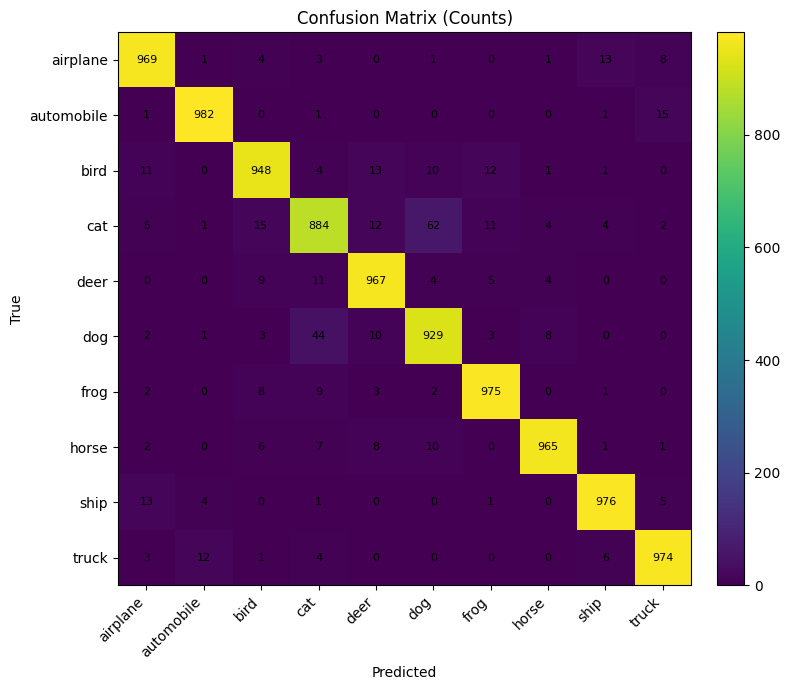

[Saved] eval_artifacts/confusion_counts.png


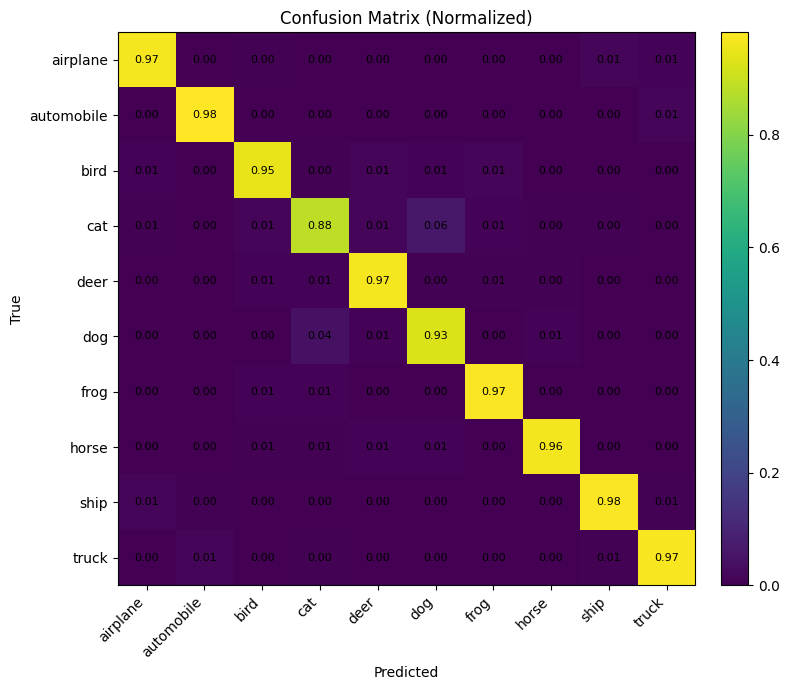

[Saved] eval_artifacts/confusion_normalized.png


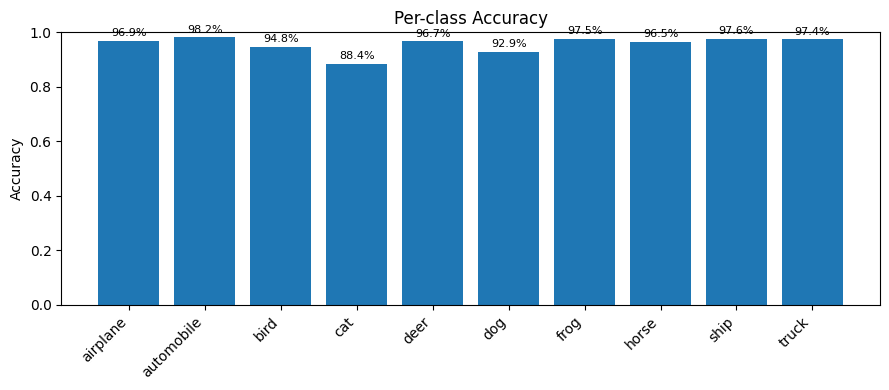

[Saved] eval_artifacts/per_class_accuracy.png


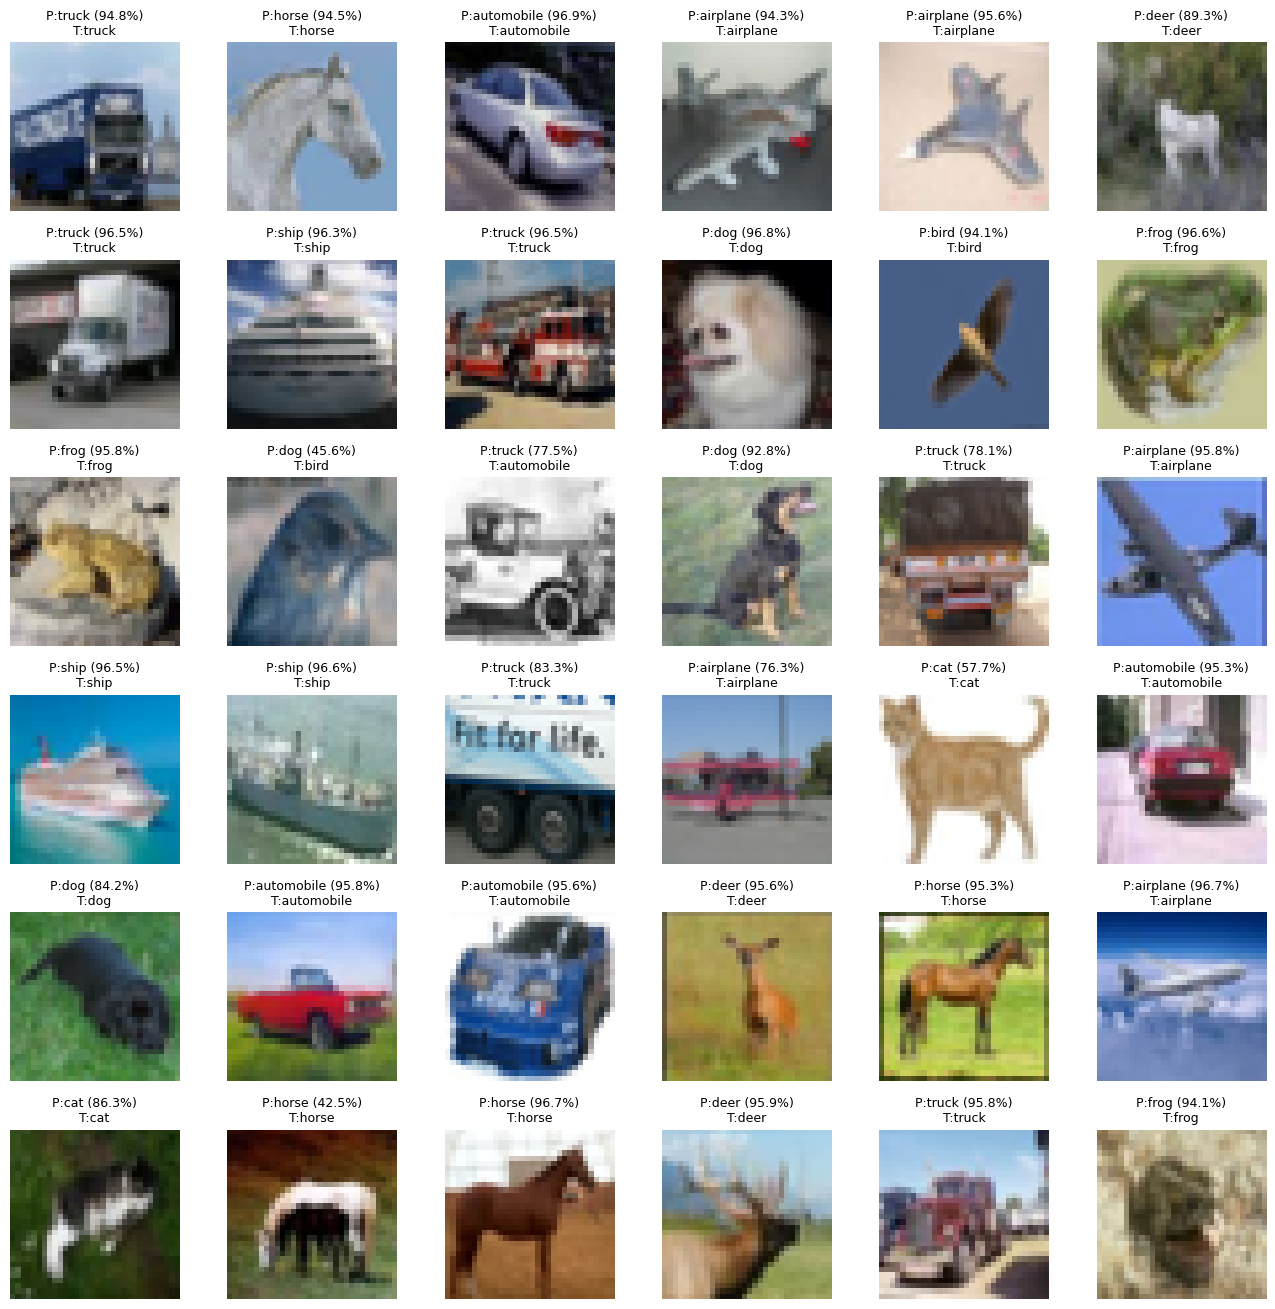

[Saved] eval_artifacts/pred_grid.png


In [ ]:
# ======================= Evaluation: metrics, plots, sample predictions =======================
import os, math, numpy as np, torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose as TvCompose, ToTensor, Normalize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

try:
    from sklearn.metrics import confusion_matrix, classification_report, top_k_accuracy_score
    _HAS_SK = True
except Exception:
    _HAS_SK = False

# ---- Config ----
CKPT_PATH          = "vit_cifar10_best.pt"   # consider trying "vit_cifar10_ema_final.pt" too
BATCH_TEST_EVAL    = 512
SAVE_DIR           = "eval_artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

# CIFAR-10 class names
CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# If test_loader is missing (e.g., running in a fresh process), rebuild it quickly.
if 'test_loader' not in globals():
    test_tfms_eval = TvCompose([ToTensor(), Normalize(MEAN, STD)])
    test_set_eval  = CIFAR10(root=".", train=False, download=True, transform=test_tfms_eval)
    test_loader    = DataLoader(test_set_eval, batch_size=BATCH_TEST_EVAL, shuffle=False,
                                num_workers=4, pin_memory=True, persistent_workers=False)

# ---------- Load helper (handles _orig_mod. / module. prefixes) ----------
def load_student_weights(model, path):
    state = torch.load(path, map_location="cpu")
    if isinstance(state, dict) and "state_dict" in state and isinstance(state["state_dict"], dict):
        state = state["state_dict"]

    if any(k.startswith("_orig_mod.") for k in state.keys()):
        state = {k.replace("_orig_mod.", "", 1): v for k, v in state.items()}
    if any(k.startswith("module.") for k in state.keys()):
        state = {k.replace("module.", "", 1): v for k, v in state.items()}

    missing, unexpected = model.load_state_dict(state, strict=False)
    print(f"[load] missing={len(missing)} unexpected={len(unexpected)}")
    if len(missing) > 50:
        first_key = next(iter(state.keys()))
        print(f"[warn] Large number of missing keys. First key example: '{first_key}'")

# ---------- Inference ----------
@torch.no_grad()
def infer_logits(model, loader, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    all_logits, all_targets = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)
        logits = model(x)  # student returns averaged (cls+dist) logits
        all_logits.append(logits.float().cpu())
        all_targets.append(y.cpu())
    return torch.cat(all_logits, dim=0).numpy(), torch.cat(all_targets, dim=0).numpy()

def per_class_accuracy(y_true, y_pred, n_classes=10):
    accs = []
    for c in range(n_classes):
        idx = (y_true == c)
        correct = np.sum((y_pred[idx] == c)) if idx.any() else 0
        acc = correct / max(1, np.sum(idx))
        accs.append(acc)
    return np.array(accs)

def plot_confusion(cm, classes, normalize=False, title="Confusion Matrix", fname="confusion.png"):
    fig, ax = plt.subplots(figsize=(8, 7))
    if normalize:
        with np.errstate(all='ignore'):
            cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
            cm_to_show = np.nan_to_num(cm_norm)
    else:
        cm_to_show = cm

    im = ax.imshow(cm_to_show, aspect='auto')
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)

    h, w = cm_to_show.shape
    for i in range(h):
        for j in range(w):
            val = cm_to_show[i, j]
            text = f"{val:.2f}" if normalize else f"{int(val)}"
            ax.text(j, i, text, ha="center", va="center", fontsize=8)

    fig.tight_layout()
    out_path = os.path.join(SAVE_DIR, fname)
    plt.savefig(out_path, dpi=160, bbox_inches='tight')
    plt.show()
    print(f"[Saved] {out_path}")

def plot_per_class_bar(accs, classes, title="Per-class Accuracy", fname="per_class_accuracy.png"):
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.bar(np.arange(len(accs)), accs)
    ax.set_ylim(0, 1.0)
    ax.set_xticks(np.arange(len(accs)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    for i, v in enumerate(accs):
        ax.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', va='bottom', fontsize=8)
    fig.tight_layout()
    out_path = os.path.join(SAVE_DIR, fname)
    plt.savefig(out_path, dpi=160, bbox_inches='tight')
    plt.show()
    print(f"[Saved] {out_path}")

def denormalize(img, mean=MEAN, std=STD):
    img = img.clone().cpu()
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    return img.permute(1,2,0).clamp(0,1).numpy()

def show_predictions_grid(model, dataset, device, n=36, fname="pred_grid.png"):
    model.eval()
    idxs = np.random.choice(len(dataset), size=min(n, len(dataset)), replace=False)
    ncols = int(math.sqrt(len(idxs)))
    nrows = int(math.ceil(len(idxs)/ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.2))
    axes = np.array(axes).reshape(nrows, ncols)

    with torch.no_grad():
        for k, ax in enumerate(axes.flatten()):
            ax.axis('off')
            if k >= len(idxs): continue
            i = idxs[k]
            x, y = dataset[i]
            x_in = x.unsqueeze(0).to(device).to(memory_format=torch.channels_last)
            logits = model(x_in)
            probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()
            pred = int(np.argmax(probs))
            conf = float(probs[pred])

            img = denormalize(x)
            ax.imshow(img)
            title = f"P:{CLASS_NAMES[pred]} ({conf*100:.1f}%)\nT:{CLASS_NAMES[y]}"
            ax.set_title(title, fontsize=9)

    fig.tight_layout()
    out_path = os.path.join(SAVE_DIR, fname)
    plt.savefig(out_path, dpi=160, bbox_inches='tight')
    plt.show()
    print(f"[Saved] {out_path}")

# ---------- Run Evaluation ----------
def evaluate_checkpoint(ckpt_path=CKPT_PATH, device="cuda" if torch.cuda.is_available() else "cpu"):
    # Build student fresh and load weights robustly
    student_eval = ViT().to(device).to(memory_format=torch.channels_last)
    load_student_weights(student_eval, ckpt_path)

    logits, y_true = infer_logits(student_eval, test_loader, device=device)
    y_pred = logits.argmax(axis=1)

    print(f"\n[Eval] Overall Top-1 Acc: {np.mean(y_pred == y_true)*100:.2f}%")

    if _HAS_SK:
        try:
            top5 = top_k_accuracy_score(y_true, logits, k=5, labels=list(range(len(CLASS_NAMES))))
            print(f"[Eval] Overall Top-5 Acc: {top5*100:.2f}%")
        except Exception:
            pass

    pc_acc = per_class_accuracy(y_true, y_pred, n_classes=len(CLASS_NAMES))
    for c, a in enumerate(pc_acc):
        print(f"  - {CLASS_NAMES[c]:>10s}: {a*100:.2f}%")

    if _HAS_SK:
        cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
    else:
        cm = np.zeros((len(CLASS_NAMES), len(CLASS_NAMES)))
        for t, p in zip(y_true, y_pred): cm[t, p] += 1

    if _HAS_SK:
        print("\nClassification report:\n")
        print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

    plot_confusion(cm, CLASS_NAMES, normalize=False, title="Confusion Matrix (Counts)",     fname="confusion_counts.png")
    plot_confusion(cm, CLASS_NAMES, normalize=True,  title="Confusion Matrix (Normalized)", fname="confusion_normalized.png")
    plot_per_class_bar(pc_acc, CLASS_NAMES, title="Per-class Accuracy", fname="per_class_accuracy.png")

    test_ds = getattr(test_loader, "dataset", CIFAR10(root=".", train=False, download=True, transform=TvCompose([ToTensor(), Normalize(MEAN, STD)])))
    show_predictions_grid(student_eval, test_ds, device, n=36, fname="pred_grid.png")

    return {"y_true": y_true, "y_pred": y_pred, "confusion": cm, "per_class_acc": pc_acc}

# Run it
# CKPT_PATH = "vit_cifar10_ema_final.pt"
results = evaluate_checkpoint(CKPT_PATH)
# ============================================================================================
